**NOTE: This notebook is written for the Google Colab platform. However it can also be run (possibly with minor modifications) as a standard Jupyter notebook.**

In [0]:
#@title -- Import of Necessary Packages -- { display-mode: "form" }
import numpy as np
import matplotlib.pyplot as plt
from sympy.utilities.lambdify import lambdify
import sympy as sp

In [0]:
#@title -- Downloading Data -- { display-mode: "form" }
!mkdir -p output

In [0]:
#@title -- Auxiliary Functions -- { display-mode: "form" }
def plot_func(xx, yy, f, X=None):
    if not X is None:
        Xmin, Xmax = X[:, 0].min(), X[:, 0].max() 
        Ymin, Ymax = X[:, 1].min(), X[:, 1].max()
        
        if (Xmin < xx.min() or Xmax > xx.max() or
                Ymin < yy.min() or Ymax > yy.max()):            
            xx = np.linspace(Xmin, Xmax, 100)
            yy = np.linspace(Ymin, Ymax, 100)
            xx, yy = np.meshgrid(xx, yy)
            
        plt.scatter(X[:, 0], X[:, 1], zorder=10)
        
    zz = f(xx, yy)
    plt.contour(xx, yy, zz, cmap='Spectral')
    # both axes at the same scale + create a legend
    plt.gca().set_aspect('equal')
    plt.xlabel('x'); plt.ylabel('y')
    plt.colorbar(label='z')
        
def grad_desc(grad_f, init_point,
              num_steps, learning_rate):
    X = np.zeros((num_steps + 1, 2))
    X[0] = init_point
    
    for i in range(num_steps):
        X[i+1] = X[i] - learning_rate * grad_f(*X[i])
    
    return X        

# Gradient Descent: An Elongated Paraboloid

In the previous notebook we have shown how to apply gradient descent to minimization of a simple paraboloid. Let's now try to apply the same procedure to a slightly more complex problem: to an elongated paraboloid. Let the function that we are going to minimize have the following form:

\begin{equation}
z = f(x, y) = (5x)^2 + y^2
\end{equation}

The main problem that we are going to be faced with is the inability to find a learning rate that would work well for both dimensions.

## Visualizing the Function

As the first step we will again define and visualize the function. We will define the function symbolically so that we can later use the automatic way to compute its symbolic gradient:

In [4]:
symx, symy = sp.symbols('x y')
symf = (5*symx)**2 + symy ** 2
symf

25*x**2 + y**2

In [0]:
f = lambdify((symx, symy), symf, "numpy")

We visualize the function using the same procedure that we applied before.

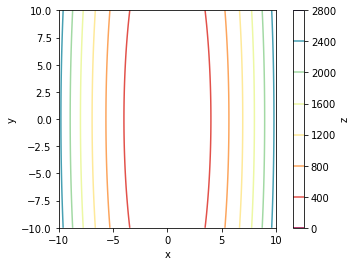

In [8]:
xx, yy = np.mgrid[-10:10.2:0.2, -10:10.2:0.2]
zz = f(xx, yy)
plot_func(xx, yy, f)

---
## Task 1: Automatically Deriving the Gradient

**Use the ``sympy`` package again to automatically derive the gradient. Then convert its symbolic form into a standard numeric function ``grad_f``:**

---

In [11]:
sym_grad_f = sp.Matrix([symf]).jacobian([symx, symy])

grad_f = lambdify((symx, symy), sym_grad_f, "numpy")

sym_grad_f

Matrix([[50*x, 2*y]])

## Minimizing the Function Using Gradient Descent

If we now try to minimize the objective function using gradient descent, we will encounter a problem: it will be difficult to come up with a learning rate that would work for both dimensions. We will either make the learning rate large and this will cause oscillation in the direction where the function decreases more quickly or we will make it small and minimization will proceed extremely slowly along the other direction.

We can test this practically. With $\gamma = 0.1$ oscillation will occur:

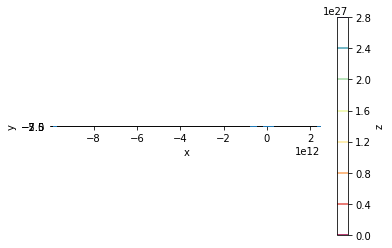

In [14]:
X = grad_desc(grad_f, init_point=[-9, -8],
              num_steps=20, learning_rate=0.1)
plot_func(xx, yy, f, X)
plt.savefig("output/grad_elongated_fast.pdf",
            bbox_inches="tight", pad_inches=0)

With $\gamma = 0.01$ the minimization will be very slow in the direction of $y$:

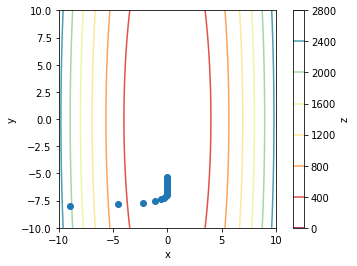

In [13]:
X = grad_desc(grad_f, init_point=[-9, -8],
              num_steps=20, learning_rate=0.01)
plot_func(xx, yy, f, X)
plt.savefig("output/grad_elongated_slow.pdf",
            bbox_inches="tight", pad_inches=0)

## Gradient Descent with Momentum

One way to counteract the problem that we have come across when applying gradient descent, is to augment the update rule with an additional term – with momentum. In that case we would take the magnitude of the change from the last iteration into account when computing a new point:

\begin{align}
\Delta \mathbf{x}_{i+1} &= \alpha \Delta \mathbf{x}_i - \gamma \nabla f(\mathbf{x}_i) \\[0.75em]
\mathbf{x}_{i+1} &= \mathbf{x}_i + \Delta \mathbf{x}_{i+1},
\end{align}
where $\alpha$ is the momentum coefficient (determines the relative importance of the change at the previous iteration $\Delta \mathbf{x}_i$).

The advantage of this is that if the minimization keeps making steps in the same direction, the momentum will accumulate and the steps in that direction will grow larger over time. And vice versa: in the direction where the algorithm oscillates, the sign of the change will keep changing, which will have the tendency to dampen the oscillation.

---
### Task 2: Add the Momentum Term

**Fill in the blanks in the following cell with the code for gradient descent with momentum (according to the formulas stated above):**

---

In [0]:
def grad_desc_momentum(grad_f, init_point,
              num_steps, learning_rate, alpha):
    X = np.zeros((num_steps + 1, 2))
    X[0] = init_point
    deltaX = 0
    
    for i in range(num_steps):
        
        deltaX =  alpha*deltaX - learning_rate*grad_f(X[i,0], X[i,1])
        X[i+1] =  X[i] + deltaX
        
    return X

Let's see now, how well our new algorithm is going to be doing on the elongated paraboloid:

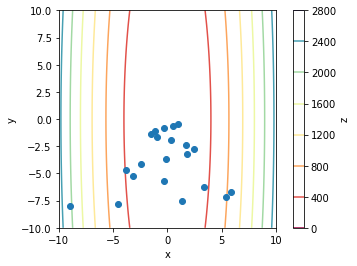

In [16]:
X = grad_desc_momentum(grad_f, init_point=[-9, -8],
              num_steps=20, learning_rate=0.01, alpha=0.8)
plot_func(xx, yy, f, X)
plt.savefig("output/grad_elongated_momentum.pdf",
            bbox_inches="tight", pad_inches=0)

As we can see, the augmented algorithm can approach the minimum without issues, because the momentum term accelerates steps along the direction where the sign of the gradient does not change for a long time and vice versa: dampens the oscillation in the direction where the minimum is being stepped over.